In [1]:
#python3 -m notebook
import os 
os.environ['CUDA_VISIBLE_DEVICES']='1'
%pylab inline
from tqdm import tqdm
import pickle


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Thu Jun 16 01:26:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:07:00.0 Off |                  N/A |
| 20%   25C    P8     8W / 250W |  10369MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 20%   

In [3]:
# from jax.lib import xla_bridge
# print(xla_bridge.get_backend().platform)
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# import GPUtil
# GPUtil.getAvailable()
# import jax
# print(torch.cuda.is_available()); print(jax.devices())
# import torch
# use_cuda = torch.cuda.is_available()
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# print(get_available_gpus())
# if use_cuda:
#     print("hello")
#     print('__CUDNN VERSION:', torch.backends.cudnn.version())
#     print('__Number CUDA Devices:', torch.cuda.device_count())
#     print('__CUDA Device Name:',torch.cuda.get_device_name(0))
#     print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

## Fitting kernel at 64**3 particles resolution

In [4]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [5]:
#export PYTHONPATH="$PYTHONPATH//home/george/CAMELS/library/build/lib"
# import sys
# sys.path.append('home/george/CAMELS/library/build/lib')
#import camels_library as cl
import readgadget
import numpy as np

init_cond = 'CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [6]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [01:31<00:00,  2.69s/it]


In [7]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)

In [8]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

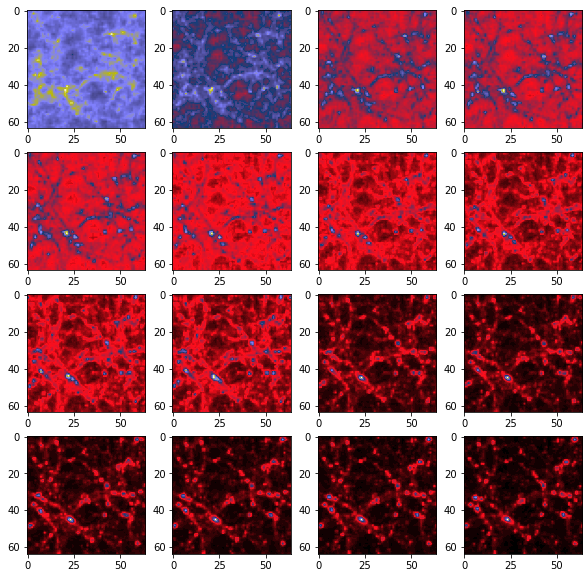

In [9]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

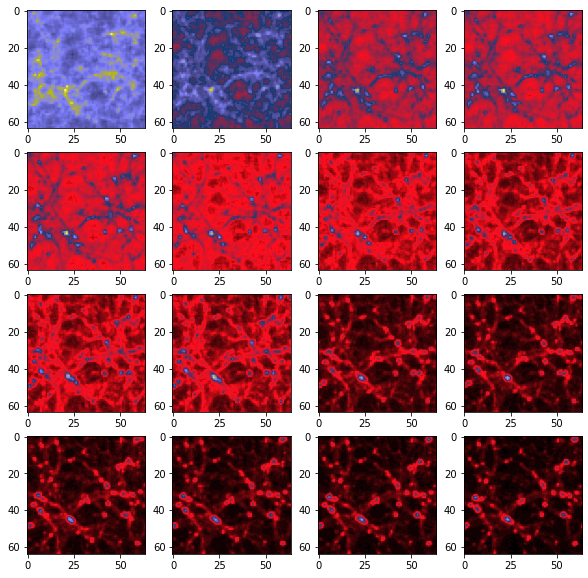

In [10]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [11]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

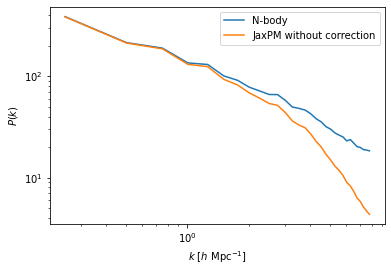

In [12]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [13]:
# Instantiate the neural network
# model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter()(x,a)))

# params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [14]:
import jax
import jax.numpy as jnp
import haiku as hk



class SpectralConv3(hk.Module):
  """Attempt"""

  def __init__(self, in_channels=1, out_channels=1, modes1=32, modes2=32, modes3=32, is_training=True, name='Layer'):

    super().__init__(name=name)
    self.name= name
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
    self.modes2 = modes2
    self.modes3 = modes3
    
    self.scale = (1 / (self.in_channels * self.out_channels))
    self.weights1= hk.get_parameter(str(self.name)+ "w1", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights2= hk.get_parameter(str(self.name)+ "w2", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights3= hk.get_parameter(str(self.name)+ "w3", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights4= hk.get_parameter(str(self.name)+ "w4", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())


  def __call__(self, pot_k):

    def compl_mul3d(input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return jnp.einsum("bixyz,ioxyz->boxyz", input, weights)
    
  
        
    self.weights1=self.weights1*self.scale
    self.weights2=self.weights2*self.scale
    self.weights3=self.weights3*self.scale
    self.weights4=self.weights4*self.scale

    batchsize=1
    
    
    #x_ft=x_ft.reshape(1,1,64,64,33)
    x_ft=pot_k
    
    _,_,dim1,dim2,dim3=x_ft.shape
    
    out_ft=jnp.zeros([batchsize, self.out_channels, dim1, dim2, dim3], dtype=float)
    out_ft=out_ft.at[:, :, :self.modes1, :self.modes2, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1))

    out_ft=out_ft.at[:, :, -self.modes1:, :self.modes2, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2))

    out_ft=out_ft.at[:, :, :self.modes1, -self.modes2:, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3))

    out_ft=out_ft.at[:, :, -self.modes1:, -self.modes2:, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4))

    

    return out_ft

In [16]:
global insideSave
insideSave=[]

class Outside(hk.Module):
    def __init__(self,width,modes1=8,modes2=8,modes3=8, padding=3,name="PaperNetwork"):
        
        super().__init__(name=name)
        self.modes1= modes1
        self.modes2= modes2
        self.modes3= modes3
        self.width = width
        self.padding=6
        self.conv0 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l0')
        self.conv1 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l1')
        self.conv2 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l2')
        self.conv3 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l3')
        self.w0 = hk.Conv3D(self.width, 1)
        self.w1 = hk.Conv3D(self.width,  1)
        self.w2 = hk.Conv3D(self.width,  1)
        self.w3 = hk.Conv3D(self.width,  1)
        self.w4 = hk.Conv3D(3,  1)
        
    def __call__(self,pot_k):

        start_p=int(self.padding)
        end_p=-start_p
        x=pot_k
        #print("Start",x.shape)
        dim1,dim2,dim3=x.shape
        x_skip=x

        #Fourier Space
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3))
        x1 = x1[jax.numpy.newaxis,jax.numpy.newaxis,...]
        x1 = self.conv0(x1)
        x1 = np.squeeze(x1, axis=0)
        x1 = jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        
        

        x = jax.numpy.pad(x, ((self.padding, self.padding), (self.padding, self.padding), (self.padding, self.padding)),mode='wrap')
        #Real Space
        x = x[...,jax.numpy.newaxis]
        x2 = self.w0(x)
        x2 = jax.numpy.transpose(x2, (3,0,1,2))
        x2= x2[:,start_p:end_p,start_p:end_p,start_p:end_p]


        x = x1 + x2 + x_skip
        x = jax.nn.gelu(x)

        x_skip=x

        #Fourier Space
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3))
        x1 = x1[jax.numpy.newaxis,...]
        x1 = self.conv1(x1)
        x1=np.squeeze(x1, axis=0)
        x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        print("fourier",x1.shape)

        print("Before Second Padding: ", x.shape)
        x = jax.numpy.pad(x, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (self.padding, self.padding)),mode='wrap')
        #Real Space
        x=jax.numpy.transpose(x, (1,2,3,0))
        x2 = self.w1(x)
        print(x2.shape)
        x2=jax.numpy.transpose(x2, (3,0,1,2))
        x2= x2[:,start_p:end_p,start_p:end_p,start_p:end_p]

        
        x = x1 + x2 + x_skip
        x = jax.nn.gelu(x)
        print(x.shape)

        x_skip=x
        #Fourier Space
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3))
        x1 = x1[jax.numpy.newaxis,...]
        x1 = self.conv2(x1)
        x1=np.squeeze(x1, axis=0)
        x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        print("fourier",x1.shape)

        print("Before Second Padding: ", x.shape)
        x = jax.numpy.pad(x, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (self.padding, self.padding)),mode='wrap')
        #Real Space
        x=jax.numpy.transpose(x, (1,2,3,0))
        x2 = self.w2(x)
        print(x2.shape)
        x2=jax.numpy.transpose(x2, (3,0,1,2))
        x2= x2[:,start_p:end_p,start_p:end_p,start_p:end_p]

        
        x = x1 + x2 + x_skip
        x = jax.nn.gelu(x)
        print(x.shape)
        
        x_skip=x
        #Fourier Space
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3))
        x1 = x1[jax.numpy.newaxis,...]
        x1 = self.conv3(x1)
        x1=np.squeeze(x1, axis=0)
        x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        print("fourier",x1.shape)

        print("Before Second Padding: ", x.shape)
        x = jax.numpy.pad(x, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (self.padding, self.padding)),mode='wrap')
        #Real Space
        x=jax.numpy.transpose(x, (1,2,3,0))
        x2 = self.w3(x)
        print(x2.shape)
        x2=jax.numpy.transpose(x2, (3,0,1,2))
        x2= x2[:,start_p:end_p,start_p:end_p,start_p:end_p]

        
        x = x1 + x2 + x_skip
        x = jax.nn.gelu(x)
        print(x.shape)        
        #Final Convolution

        x=jax.numpy.transpose(x, (1,2,3,0))
        x = self.w4(x)
        print(x.shape)


        return x
        

model = hk.without_apply_rng(hk.transform(lambda x : Outside(width=10,modes1=32,modes2=32,modes3=32)(x)))

params = model.init(next(rng_seq),jnp.ones((64,64,64)))

fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
(64, 64, 64, 3)


In [17]:

def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    #Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # # Apply a correction filter
    # kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    
    #pot_k = pot_k*0.99 + model.apply(params, pot_k)
    #print(model.apply(params, kk, jnp.atleast_1d(a)))
    # Computes gravitational forces
    forces =   jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) for i in range(3)],axis=-1)
    #global saved
    modelx=model.apply(params, delta)
   
        
    forcesML=jnp.stack([cic_read(modelx[...,i],pos) for i in range(3)],axis=-1)

    # forces=  model.apply(params, delta) # +forces
    forces= forces+ forcesML
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [ ]:
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)

@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)
  # Optional lines to include velocity in the loss
  vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
  wv = jnp.where(distance < 100, vel, 0.)
  return 0.01*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [ ]:
losses = []

In [ ]:

import optax
lr_fun= optax.cosine_decay_schedule(0.5, 1000 , alpha=0.0)
#learning_rate=0.001
optimizer = optax.adam(lr_fun)
opt_state = optimizer.init(params)

In [71]:
for step in tqdm(range(10000)):
  l, params, opt_state = update(params, opt_state)
  if(step%10==0):
    print("Step: ", step, " Loss: ",l)
  losses.append(l)

  0%|          | 1/10000 [00:19<53:12:32, 19.16s/it]

Step:  0  Loss:  0.3426292


  0%|          | 11/10000 [03:27<52:33:56, 18.94s/it]

Step:  10  Loss:  0.34291


  0%|          | 21/10000 [06:36<52:22:35, 18.90s/it]

Step:  20  Loss:  0.33678982


  0%|          | 31/10000 [09:44<52:04:51, 18.81s/it]

Step:  30  Loss:  0.33197978


  0%|          | 41/10000 [12:54<52:05:43, 18.83s/it]

Step:  40  Loss:  0.3289746


  1%|          | 51/10000 [16:03<52:23:03, 18.96s/it]

Step:  50  Loss:  0.32563117


  1%|          | 61/10000 [19:12<52:32:01, 19.03s/it]

Step:  60  Loss:  0.32125035


  1%|          | 71/10000 [22:23<52:41:47, 19.11s/it]

Step:  70  Loss:  0.32194555


  1%|          | 81/10000 [25:34<52:35:51, 19.09s/it]

Step:  80  Loss:  0.31646103


  1%|          | 91/10000 [28:45<52:58:25, 19.25s/it]

Step:  90  Loss:  0.31201267


  1%|          | 101/10000 [31:59<53:31:25, 19.47s/it]

Step:  100  Loss:  0.3088938


  1%|          | 111/10000 [35:14<53:25:47, 19.45s/it]

Step:  110  Loss:  0.30550668


  1%|          | 121/10000 [38:30<54:05:25, 19.71s/it]

Step:  120  Loss:  0.30220562


  1%|▏         | 131/10000 [41:47<54:15:54, 19.79s/it]

Step:  130  Loss:  0.30063036


  1%|▏         | 141/10000 [45:06<54:08:30, 19.77s/it]

Step:  140  Loss:  0.2966538


  2%|▏         | 151/10000 [48:29<55:38:41, 20.34s/it]

Step:  150  Loss:  0.29418564


  2%|▏         | 161/10000 [51:50<54:58:42, 20.12s/it]

Step:  160  Loss:  0.2913113


  2%|▏         | 171/10000 [55:13<55:38:18, 20.38s/it]

Step:  170  Loss:  0.29049447


  2%|▏         | 181/10000 [58:36<55:23:29, 20.31s/it]

Step:  180  Loss:  0.2868351


  2%|▏         | 191/10000 [1:01:59<55:20:37, 20.31s/it]

Step:  190  Loss:  0.28412578


  2%|▏         | 201/10000 [1:05:21<54:51:03, 20.15s/it]

Step:  200  Loss:  0.2835421


  2%|▏         | 211/10000 [1:08:44<54:39:06, 20.10s/it]

Step:  210  Loss:  0.2799912


  2%|▏         | 221/10000 [1:12:06<54:55:43, 20.22s/it]

Step:  220  Loss:  0.2786251


  2%|▏         | 231/10000 [1:15:28<55:07:52, 20.32s/it]

Step:  230  Loss:  0.27597523


  2%|▏         | 241/10000 [1:18:52<55:06:48, 20.33s/it]

Step:  240  Loss:  0.2747705


  3%|▎         | 251/10000 [1:22:14<54:32:39, 20.14s/it]

Step:  250  Loss:  0.2736413


  3%|▎         | 261/10000 [1:25:37<55:11:30, 20.40s/it]

Step:  260  Loss:  0.27166235


  3%|▎         | 271/10000 [1:29:00<54:53:00, 20.31s/it]

Step:  270  Loss:  0.2692703


  3%|▎         | 281/10000 [1:32:23<55:01:48, 20.38s/it]

Step:  280  Loss:  0.26748115


  3%|▎         | 291/10000 [1:35:47<55:13:48, 20.48s/it]

Step:  290  Loss:  0.2663387


  3%|▎         | 301/10000 [1:39:10<54:44:01, 20.32s/it]

Step:  300  Loss:  0.26444322


  3%|▎         | 311/10000 [1:42:34<54:51:38, 20.38s/it]

Step:  310  Loss:  0.26321724


  3%|▎         | 321/10000 [1:45:59<55:20:22, 20.58s/it]

Step:  320  Loss:  0.26254788


  3%|▎         | 331/10000 [1:49:25<55:02:57, 20.50s/it]

Step:  330  Loss:  0.26077121


  3%|▎         | 341/10000 [1:52:50<55:04:10, 20.52s/it]

Step:  340  Loss:  0.25967276


  4%|▎         | 351/10000 [1:56:16<55:08:30, 20.57s/it]

Step:  350  Loss:  0.25826558


  4%|▎         | 361/10000 [1:59:43<55:19:31, 20.66s/it]

Step:  360  Loss:  0.25714323


  4%|▎         | 371/10000 [2:03:09<55:17:47, 20.67s/it]

Step:  370  Loss:  0.25601286


  4%|▍         | 381/10000 [2:06:36<55:14:33, 20.68s/it]

Step:  380  Loss:  0.25483963


  4%|▍         | 391/10000 [2:10:04<55:56:32, 20.96s/it]

Step:  390  Loss:  0.2545104


  4%|▍         | 401/10000 [2:13:29<54:33:52, 20.46s/it]

Step:  400  Loss:  0.25364542


  4%|▍         | 411/10000 [2:16:56<55:02:56, 20.67s/it]

Step:  410  Loss:  0.25241143


  4%|▍         | 421/10000 [2:20:23<54:52:49, 20.63s/it]

Step:  420  Loss:  0.25139612


  4%|▍         | 431/10000 [2:23:50<55:18:01, 20.80s/it]

Step:  430  Loss:  0.25081962


  4%|▍         | 441/10000 [2:27:18<55:16:35, 20.82s/it]

Step:  440  Loss:  0.24998218


  5%|▍         | 451/10000 [2:30:47<55:12:38, 20.81s/it]

Step:  450  Loss:  0.24922933


  5%|▍         | 461/10000 [2:34:15<55:16:44, 20.86s/it]

Step:  460  Loss:  0.24852732


  5%|▍         | 471/10000 [2:37:44<55:24:47, 20.93s/it]

Step:  470  Loss:  0.24793316


  5%|▍         | 481/10000 [2:41:15<55:34:31, 21.02s/it]

Step:  480  Loss:  0.24730411


  5%|▍         | 491/10000 [2:44:45<55:22:39, 20.97s/it]

Step:  490  Loss:  0.24681614


  5%|▌         | 501/10000 [2:48:13<55:08:11, 20.90s/it]

Step:  500  Loss:  0.24637985


  5%|▌         | 511/10000 [2:51:44<55:54:24, 21.21s/it]

Step:  510  Loss:  0.24582966


  5%|▌         | 521/10000 [2:55:16<55:31:20, 21.09s/it]

Step:  520  Loss:  0.24536896


  5%|▌         | 531/10000 [2:58:46<55:10:34, 20.98s/it]

Step:  530  Loss:  0.24497163


  5%|▌         | 541/10000 [3:02:16<55:10:07, 21.00s/it]

Step:  540  Loss:  0.24461725


  6%|▌         | 551/10000 [3:05:46<55:07:30, 21.00s/it]

Step:  550  Loss:  0.24430302


  6%|▌         | 561/10000 [3:09:17<55:24:58, 21.14s/it]

Step:  560  Loss:  0.24409562


  6%|▌         | 571/10000 [3:12:46<54:41:48, 20.88s/it]

Step:  570  Loss:  0.24375969


  6%|▌         | 581/10000 [3:16:15<54:44:33, 20.92s/it]

Step:  580  Loss:  0.24345711


  6%|▌         | 591/10000 [3:19:44<54:51:11, 20.99s/it]

Step:  590  Loss:  0.24321362


  6%|▌         | 601/10000 [3:23:14<54:58:09, 21.05s/it]

Step:  600  Loss:  0.2429955


  6%|▌         | 611/10000 [3:26:44<54:37:38, 20.95s/it]

Step:  610  Loss:  0.24280576


  6%|▌         | 621/10000 [3:30:14<54:47:35, 21.03s/it]

Step:  620  Loss:  0.24264501


  6%|▋         | 631/10000 [3:33:44<54:51:29, 21.08s/it]

Step:  630  Loss:  0.24250281


  6%|▋         | 641/10000 [3:37:13<54:23:39, 20.92s/it]

Step:  640  Loss:  0.24238564


  7%|▋         | 651/10000 [3:40:43<54:22:29, 20.94s/it]

Step:  650  Loss:  0.2422803


  7%|▋         | 661/10000 [3:44:12<54:09:41, 20.88s/it]

Step:  660  Loss:  0.2421866


  7%|▋         | 671/10000 [3:47:41<54:09:55, 20.90s/it]

Step:  670  Loss:  0.24211359


  7%|▋         | 681/10000 [3:51:10<54:04:18, 20.89s/it]

Step:  680  Loss:  0.24204922


  7%|▋         | 691/10000 [3:54:39<54:19:37, 21.01s/it]

Step:  690  Loss:  0.24200639


  7%|▋         | 701/10000 [3:58:08<54:05:08, 20.94s/it]

Step:  700  Loss:  0.24196678


  7%|▋         | 711/10000 [4:01:38<53:59:31, 20.92s/it]

Step:  710  Loss:  0.2419461


  7%|▋         | 721/10000 [4:05:07<54:07:30, 21.00s/it]

Step:  720  Loss:  0.24192354


  7%|▋         | 731/10000 [4:08:37<53:50:45, 20.91s/it]

Step:  730  Loss:  0.2419093


  7%|▋         | 741/10000 [4:12:06<53:55:09, 20.96s/it]

Step:  740  Loss:  0.24190502


  8%|▊         | 751/10000 [4:15:36<53:54:15, 20.98s/it]

Step:  750  Loss:  0.24189758


  8%|▊         | 761/10000 [4:19:05<53:36:37, 20.89s/it]

Step:  760  Loss:  0.24189568


  8%|▊         | 771/10000 [4:22:34<53:35:34, 20.91s/it]

Step:  770  Loss:  0.24189475


  8%|▊         | 781/10000 [4:26:02<53:22:21, 20.84s/it]

Step:  780  Loss:  0.24189612


  8%|▊         | 791/10000 [4:29:31<53:26:22, 20.89s/it]

Step:  790  Loss:  0.24189587


  8%|▊         | 801/10000 [4:33:00<53:22:04, 20.89s/it]

Step:  800  Loss:  0.2418938


  8%|▊         | 811/10000 [4:36:29<53:19:06, 20.89s/it]

Step:  810  Loss:  0.24189505


  8%|▊         | 821/10000 [4:39:58<53:18:31, 20.91s/it]

Step:  820  Loss:  0.24189404


  8%|▊         | 831/10000 [4:43:27<53:13:03, 20.89s/it]

Step:  830  Loss:  0.24189804


  8%|▊         | 841/10000 [4:46:56<53:13:37, 20.92s/it]

Step:  840  Loss:  0.24189542


  9%|▊         | 851/10000 [4:50:26<53:23:04, 21.01s/it]

Step:  850  Loss:  0.24189474


  9%|▊         | 861/10000 [4:53:55<53:02:31, 20.89s/it]

Step:  860  Loss:  0.24189611


  9%|▊         | 871/10000 [4:57:24<53:01:19, 20.91s/it]

Step:  870  Loss:  0.2418946


  9%|▉         | 881/10000 [5:00:53<52:58:44, 20.92s/it]

Step:  880  Loss:  0.24190053


  9%|▉         | 891/10000 [5:04:22<52:55:46, 20.92s/it]

Step:  890  Loss:  0.24189827


  9%|▉         | 901/10000 [5:07:52<53:08:22, 21.02s/it]

Step:  900  Loss:  0.2418918


  9%|▉         | 911/10000 [5:11:21<52:48:34, 20.92s/it]

Step:  910  Loss:  0.24189198


  9%|▉         | 921/10000 [5:14:51<52:47:18, 20.93s/it]

Step:  920  Loss:  0.24189746


  9%|▉         | 931/10000 [5:18:20<52:38:28, 20.90s/it]

Step:  930  Loss:  0.2418952


  9%|▉         | 941/10000 [5:21:49<52:25:11, 20.83s/it]

Step:  940  Loss:  0.24189666


 10%|▉         | 951/10000 [5:25:18<52:36:06, 20.93s/it]

Step:  950  Loss:  0.24189833


 10%|▉         | 961/10000 [5:28:48<52:34:50, 20.94s/it]

Step:  960  Loss:  0.24189523


 10%|▉         | 971/10000 [5:32:17<52:48:37, 21.06s/it]

Step:  970  Loss:  0.24189435


 10%|▉         | 981/10000 [5:35:46<52:24:34, 20.92s/it]

Step:  980  Loss:  0.24189362


 10%|▉         | 991/10000 [5:39:15<52:16:54, 20.89s/it]

Step:  990  Loss:  0.24189514


 10%|█         | 1001/10000 [5:42:45<52:20:05, 20.94s/it]

Step:  1000  Loss:  0.2418971


 10%|█         | 1011/10000 [5:46:14<52:15:05, 20.93s/it]

Step:  1010  Loss:  0.24189499


 10%|█         | 1021/10000 [5:49:43<52:09:05, 20.91s/it]

Step:  1020  Loss:  0.2418988


 10%|█         | 1031/10000 [5:53:12<52:04:13, 20.90s/it]

Step:  1030  Loss:  0.24189834


 10%|█         | 1041/10000 [5:56:42<52:11:26, 20.97s/it]

Step:  1040  Loss:  0.24189526


 11%|█         | 1051/10000 [6:00:12<52:08:00, 20.97s/it]

Step:  1050  Loss:  0.24189705


 11%|█         | 1053/10000 [6:01:14<51:09:24, 20.58s/it]


KeyboardInterrupt: 

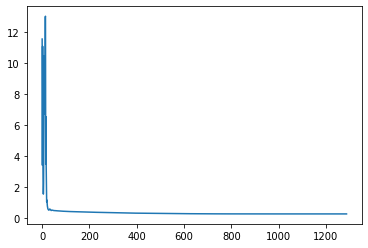

In [72]:
plot(losses)


In [65]:
losses[-1]

DeviceArray(0.34292403, dtype=float32)

In [73]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

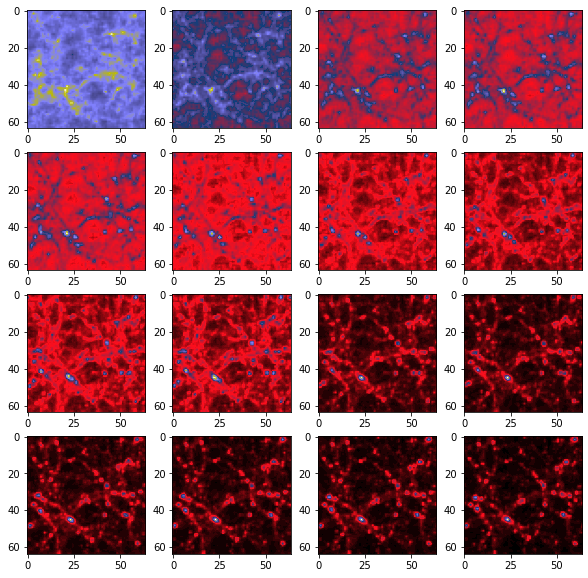

In [74]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [76]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

Text(0, 0.5, '$P(k)$')

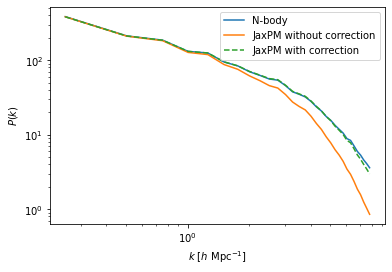

In [77]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [70]:
print(ERRROOR)

NameError: name 'ERRROOR' is not defined

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


NameError: name 'col' is not defined

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

NameError: name 'col' is not defined

In [ ]:
import pickle
pickle.dump( params, open( "DL_20_970steps_05lr.params", "wb" ) )

In [ ]:
pos, vel = poss[0], vels[0]

kvec = fftk(mesh_shape)

delta = cic_paint(jnp.zeros(mesh_shape), pos)

delta_k = jnp.fft.rfftn(delta)

# Computes gravitational potential
pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
#print(pot_k.shape)
# Apply a correction filter
kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a)))
#print(model.apply(params, kk, jnp.atleast_1d(a)))
# Computes gravitational forces
forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                    for i in range(3)],axis=-1)

forces = forces * 1.5 * cosmo.Omega_m

# Computes the update of position (drift)
dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel

# Computes the update of velocity (kick)
dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces

[[[0.         0.05065344 0.08016984 ... 0.49547923 0.49452972 0.48018762]
  [0.05065344 0.06523284 0.08445517 ... 0.49558228 0.494399   0.4798689 ]
  [0.08016984 0.08445517 0.09124874 ... 0.4958673  0.49398628 0.4788973 ]
  ...
  [0.09223951 0.09280366 0.09262511 ... 0.49626184 0.4932313  0.47722763]
  [0.08016984 0.08445517 0.09124874 ... 0.4958673  0.49398628 0.4788973 ]
  [0.05065344 0.06523284 0.08445517 ... 0.49558228 0.494399   0.4798689 ]]

 [[0.05065344 0.06523284 0.08445517 ... 0.49558228 0.494399   0.4798689 ]
  [0.06523284 0.07412502 0.08753303 ... 0.49568126 0.49426475 0.47954756]
  [0.08445517 0.08753303 0.09223951 ... 0.4959543  0.49384198 0.47856843]
  ...
  [0.09280366 0.09301847 0.09210111 ... 0.49632865 0.49307042 0.47688612]
  [0.08445517 0.08753303 0.09223951 ... 0.4959543  0.49384198 0.47856843]
  [0.06523284 0.07412502 0.08753303 ... 0.49568126 0.49426475 0.47954756]]

 [[0.08016984 0.08445517 0.09124874 ... 0.4958673  0.49398628 0.4788973 ]
  [0.08445517 0.087533

/tmp/ipykernel_1965088/2922459305.py:13: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))


In [ ]:
x2=(model.apply(params, kk, jnp.atleast_1d(a)))
x2.shape

[[[0.         0.05065344 0.08016984 ... 0.49547923 0.49452972 0.48018762]
  [0.05065344 0.06523284 0.08445517 ... 0.49558228 0.494399   0.4798689 ]
  [0.08016984 0.08445517 0.09124874 ... 0.4958673  0.49398628 0.4788973 ]
  ...
  [0.09223951 0.09280366 0.09262511 ... 0.49626184 0.4932313  0.47722763]
  [0.08016984 0.08445517 0.09124874 ... 0.4958673  0.49398628 0.4788973 ]
  [0.05065344 0.06523284 0.08445517 ... 0.49558228 0.494399   0.4798689 ]]

 [[0.05065344 0.06523284 0.08445517 ... 0.49558228 0.494399   0.4798689 ]
  [0.06523284 0.07412502 0.08753303 ... 0.49568126 0.49426475 0.47954756]
  [0.08445517 0.08753303 0.09223951 ... 0.4959543  0.49384198 0.47856843]
  ...
  [0.09280366 0.09301847 0.09210111 ... 0.49632865 0.49307042 0.47688612]
  [0.08445517 0.08753303 0.09223951 ... 0.4959543  0.49384198 0.47856843]
  [0.06523284 0.07412502 0.08753303 ... 0.49568126 0.49426475 0.47954756]]

 [[0.08016984 0.08445517 0.09124874 ... 0.4958673  0.49398628 0.4788973 ]
  [0.08445517 0.087533

(64, 64, 33)

In [ ]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

In [ ]:
len(res[0])

34

In [ ]:
f = lambda x,a : NeuralSplineFourierFilter()(x,a)
x = jnp.ones([8, 28 * 28])
for i in hk.experimental.eval_summary(f)(x,a):
  print("mod := {:14} | in := {} out := {}".format(
      i.module_details.module.module_name, i.args_spec[0], i.output_spec))

mod := neural_spline_fourier_filter | in := f32[8,784] out := f32[8,784]
mod := neural_spline_fourier_filter/linear | in := f32[1] out := f32[16]
mod := neural_spline_fourier_filter/linear_1 | in := f32[16] out := f32[16]
mod := neural_spline_fourier_filter/linear_2 | in := f32[16] out := f32[9]
mod := neural_spline_fourier_filter/linear_3 | in := f32[16] out := f32[7]


In [ ]:
x = jnp.ones([8, 28 * 28])
f = hk.transform(NeuralSplineFourierFilter)
print(hk.experimental.tabulate(f)(kk))

No modules matching filters.


In [ ]:

class SpectralConv(hk.Module):
  """Attempt"""

  def __init__(self, in_channels=1, out_channels=1, modes1=32, modes2=32, modes3=32, is_training=True, name=None):

    super().__init__(name=name)
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
    self.modes2 = modes2
    self.modes3 = modes3
    
    self.scale = (1 / (self.in_channels * self.out_channels))
#     self.weights1= None #=hk.get_parameter("w", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
#     self.weights2= None #=hk.get_parameter("w", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
#     self.weights3= None #=hk.get_parameter("w", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
#     self.weights4= None # hk.get_parameter("w", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)


  def __call__(self, pot_k):

    def compl_mul3d(input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return jnp.einsum("bixyz,ioxyz->boxyz", input, weights)
    
    def main_fun(x_ft,in_channelsX,out_channelsX):
        weights1=hk.get_parameter("w1"+str(in_channelsX/out_channelsX), shape=[in_channelsX, out_channelsX, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
        weights2=hk.get_parameter("w2"+str(in_channelsX/out_channelsX), shape=[in_channelsX, out_channelsX, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
        weights3=hk.get_parameter("w3"+str(in_channelsX/out_channelsX), shape=[in_channelsX, out_channelsX, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
        weights4=hk.get_parameter("w4"+str(in_channelsX/out_channelsX), shape=[in_channelsX, out_channelsX, self.modes1, self.modes2, self.modes3], dtype=float, init=jnp.ones)
        weights1=weights1*self.scale
        weights2=weights2*self.scale
        weights3=weights3*self.scale
        weights4=weights4*self.scale


        batchsize=1
        out_ft=jnp.zeros([batchsize, out_channelsX, 64, 64, 33], dtype=float)

        out_ft=out_ft.at[:, :, :self.modes1, :self.modes2, :self.modes3]. \
        set(compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], weights1))

        out_ft=out_ft.at[:, :, -self.modes1:, :self.modes2, :self.modes3]. \
        set(compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], weights2))

        out_ft=out_ft.at[:, :, :self.modes1, -self.modes2:, :self.modes3]. \
        set(compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], weights3))

        out_ft=out_ft.at[:, :, -self.modes1:, -self.modes2:, :self.modes3]. \
        set(compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], weights4))

        return out_ft
    
    
    x_ft=pot_k
    x_ft=x_ft.reshape(1,1,64,64,33)

    out_ft=main_fun(x_ft,1,1)
    #out_ft=main_fun(out_ft,3,1)
    
    #out_ft=out_ft.reshape(64,64,33)
    return out_ft.reshape(64,64,33)

In [18]:
import pickle
with (open("FullDeepRes10_05lr_Cor.params", "rb")) as openfile:
    while True:
        try:
            paramsLoad=pickle.load(openfile)
        except EOFError:
            break

In [19]:

pos, vel = poss[0],vels[0]

kvec = fftk(mesh_shape)

delta = cic_paint(jnp.zeros(mesh_shape), pos)

delta_k = jnp.fft.rfftn(delta)

#Computes gravitational potential
pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)

# # Apply a correction filter

# Computes gravitational forces
forces =   jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) for i in range(3)],axis=-1)
#global saved
modelx=model.apply(paramsLoad, delta)
# print(modelx.shape)
# neural_nbody_ode.savedx= jax.numpy.copy(modelx)
# print(neural_nbody_ode.savedx)
# import dill as dill
# with open('modelxArr.txt', 'wb') as f:
#     dill.dump(modelx, f)
# jax.numpy.savetx("modelxArr",modelx)
    
forcesML=jnp.stack([cic_read(modelx[...,i],pos) for i in range(3)],axis=-1)

# forces=  model.apply(params, delta) # +forces
forces= forces+ forcesML
forces = forces * 1.5 * cosmo.Omega_m



/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/ops/scatter.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
fourier (10, 64, 64, 64)
Before Second Padding:  (10, 64, 64, 64)
(76, 76, 76, 10)
(10, 64, 64, 64)
(64, 64, 64, 3)


In [20]:
data=modelx
print(data.shape)
#data=numpy.array(data)
dim1,dim2,dim3,dim4=data.shape

(64, 64, 64, 3)


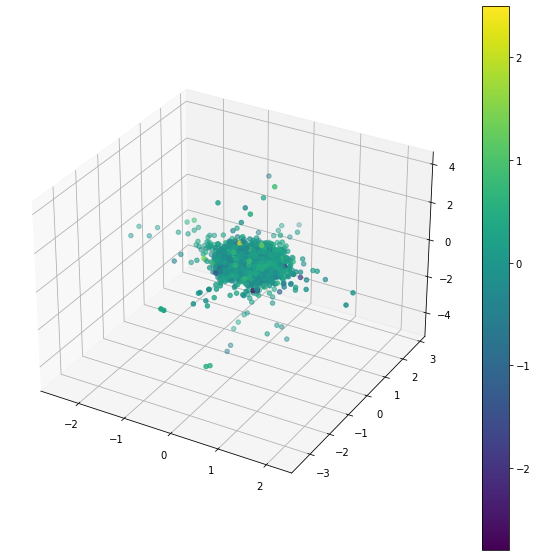

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

sp = ax.scatter(data[:,0],data[:,1],data[:,2], s=20, c=data[:,3])
plt.colorbar(sp)

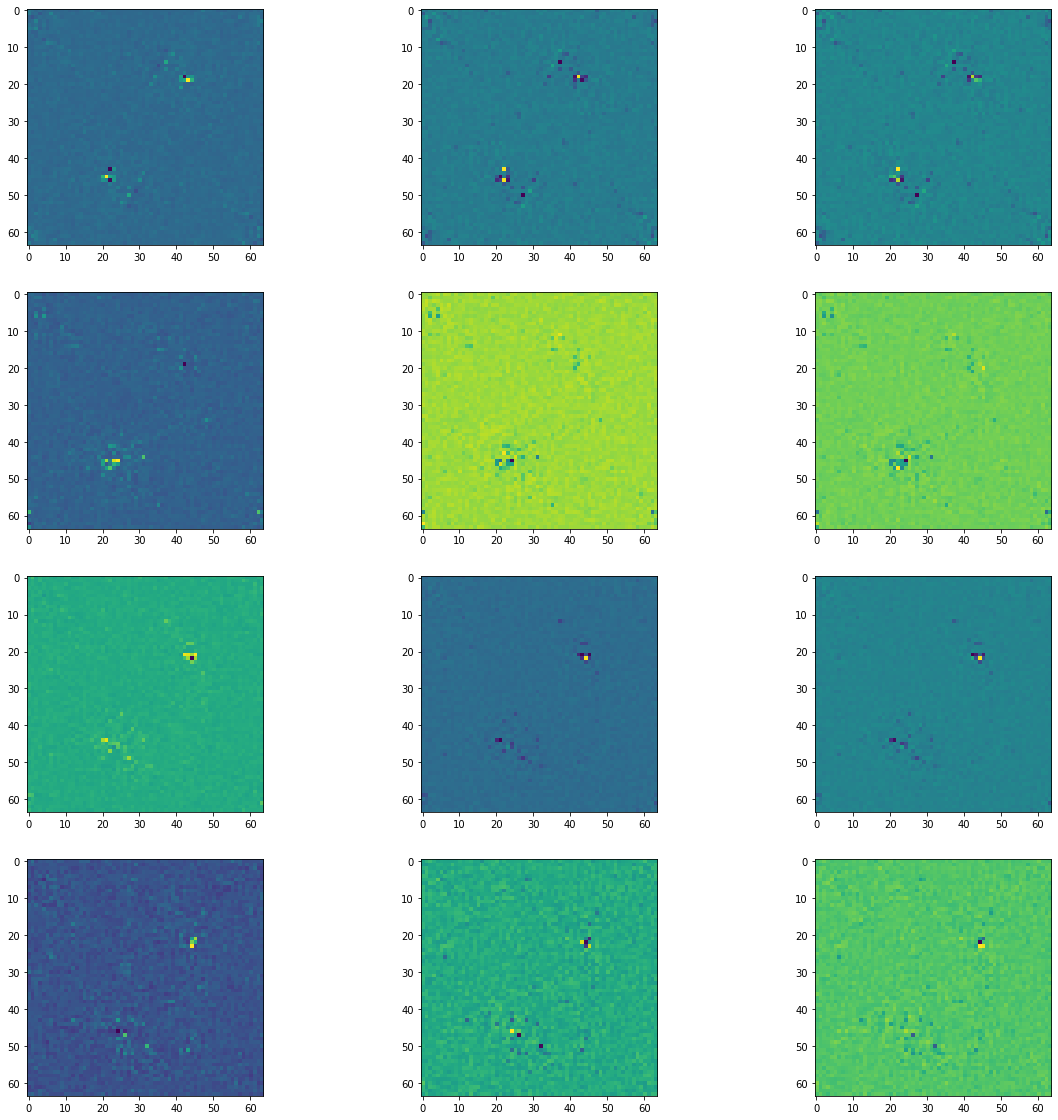

In [22]:
imgs=[]
minus=60

for i in range(dim1-minus):
    for j in range(dim4):
        imgs.append(data[i,:,:,j])


_, axs = plt.subplots(dim1-minus, dim4, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

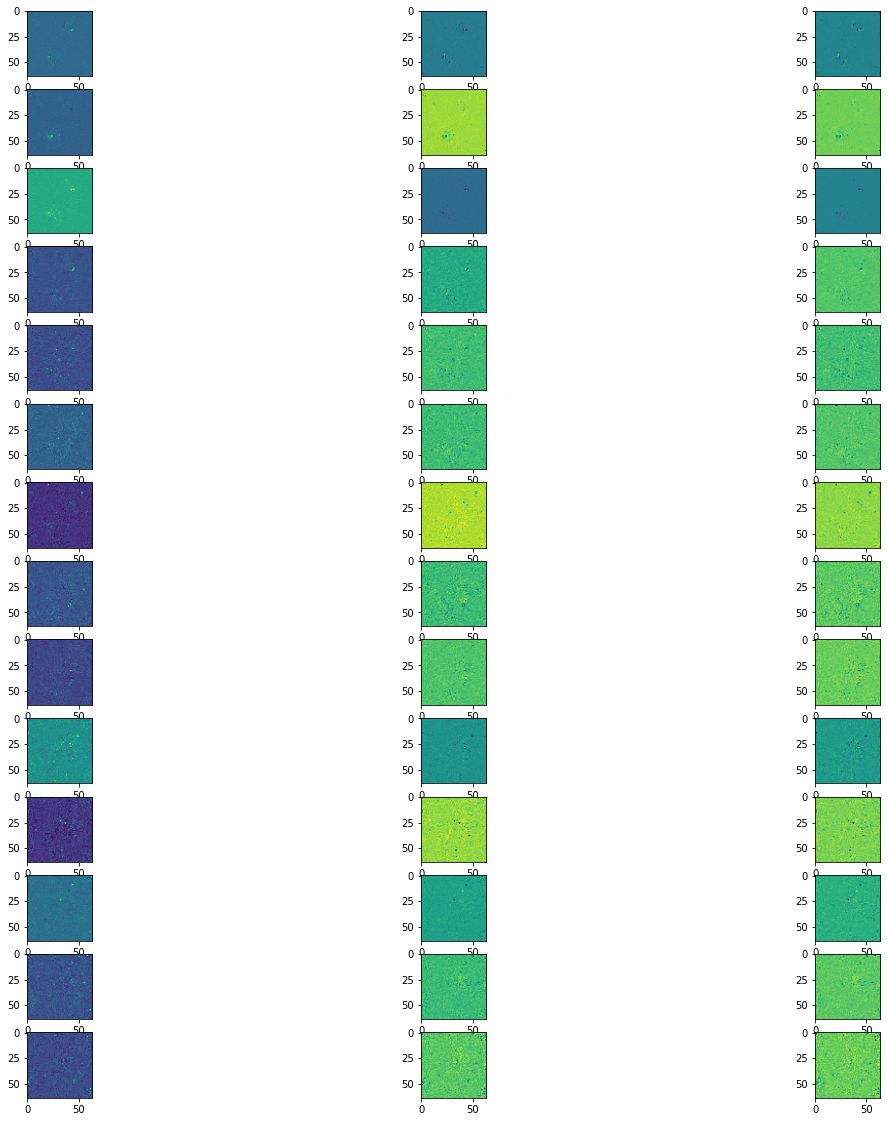

In [23]:
imgs=[]
minus=50

for i in range(dim1-minus):
    for j in range(dim4):
        imgs.append(data[i,:,:,j])


_, axs = plt.subplots(dim1-minus, dim4, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [78]:
import pickle
pickle.dump( params, open( "FullDeepRes10_05lr_Cor.params", "wb" ) )

In [ ]:
import jax
import jax.numpy as jnp
import jax.lax as lax

from jaxpm.kernels import fftk, cic_compensation

def cic_paint_vel(mesh, positions,weight=None):
  """ Paints positions onto mesh
  mesh: [nx, ny, nz]
  positions: [npart, 3]
  """
  positions = jnp.expand_dims(positions, 1)
  floor = jnp.floor(positions)
  connection = jnp.array([[[0, 0, 0], [1., 0, 0], [0., 1, 0], 
                           [0., 0, 1], [1., 1, 0], [1., 0, 1], 
                           [0., 1, 1], [1., 1, 1]]])

  neighboor_coords = floor + connection
  kernel = 1. - jnp.abs(positions - neighboor_coords)
  kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]  

  if weight is not None:
      kernel = jax.numpy.multiply(jax.numpy.expand_dims(weight, axis=-1), kernel)

  neighboor_coords = jnp.mod(neighboor_coords.reshape([-1,8,3]).astype('int32'), jnp.array(mesh.shape))

  dnums = jax.lax.ScatterDimensionNumbers(
    update_window_dims=(),
    inserted_window_dims=(0, 1, 2),
    scatter_dims_to_operand_dims=(0, 1, 2))
  mesh = lax.scatter_add(mesh, 
                         neighboor_coords, 
                         kernel.reshape([-1,8]),
                         dnums)
  return mesh

In [ ]:
pos, vel = poss[0], vels[0]

kvec = fftk(mesh_shape)

delta = cic_paint_vel(jnp.zeros(mesh_shape), pos, vel)


ValueError: Incompatible shapes for broadcasting: ((262144, 3, 1), (1, 262144, 8))